In [2]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt

2025-03-30 09:17:09.880217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743313629.894034    6020 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743313629.898435    6020 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743313629.910593    6020 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743313629.910610    6020 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743313629.910612    6020 computation_placer.cc:177] computation placer alr

In [3]:
model_name = "openai/clip-vit-base-patch32"
model_name = "immich-app/ViT-B-32__laion400m_e32"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import torchvision

class ProcessorGradientFlow():
    """
    This wraps the huggingface CLIP processor to allow backprop through the image processing step.
    The original processor forces conversion to numpy then PIL images, which is faster for image processing but breaks gradient flow. 
    """
    def __init__(self, model_name, device="cuda") -> None:
        self.device = device
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.image_mean = [0.48145466, 0.4578275, 0.40821073]
        self.image_std = [0.26862954, 0.26130258, 0.27577711]
        self.normalize = torchvision.transforms.Normalize(
            self.image_mean,
            self.image_std
        )
        self.resize = torchvision.transforms.Resize(224)
        self.center_crop = torchvision.transforms.CenterCrop(224)
    
    def preprocess_img(self, images):
        images = self.center_crop(images)
        images = self.resize(images)
        images = self.center_crop(images)
        images = self.normalize(images)
        return images
    
    def __call__(self, images=[], **kwargs):
        processed_inputs = self.processor(**kwargs)
        processed_inputs["pixel_values"] = self.preprocess_img(images)
        processed_inputs = {key:value.to(self.device) for (key, value) in processed_inputs.items()}
        return processed_inputs


In [6]:
model_name = "immich-app/ViT-B-32__laion400m_e32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = ProcessorGradientFlow(model_name, device)

print(f"Loaded {model_name} on {device}")

OSError: immich-app/ViT-B-32__laion400m_e32 does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

In [8]:
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms


def predict_similarity(image, texts):
    inputs = processor(text=texts, images=image,
                       return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    return probs.cpu().numpy()


def denormalize(
    pixel_values,
    mean=torch.tensor([0.481, 0.457, 0.408]),
    std=torch.tensor([0.268, 0.261, 0.275]),
):
    transform = transforms.ToPILImage()
    mean = mean.view(1, 3, 1, 1)
    std = std.view(1, 3, 1, 1)

    denormalized_imgs = pixel_values * std + mean
    denormalized_imgs = denormalized_imgs.clamp(0, 1)
    denormalized_imgs = [transform(img) for img in denormalized_imgs]

    if len(denormalized_imgs) == 1:
        return denormalized_imgs[0]
    else:
        return denormalized_imgs


def train_adversarial_example(target_text, image_size=224, learning_rate=1e-1, num_steps=500):
    input_tensor_shape = (1, 3, image_size, image_size)

    adversarial_image = torch.rand(
        input_tensor_shape, device=device, requires_grad=True)

    optimizer = torch.optim.Adam([adversarial_image], lr=learning_rate)

    for step in range(num_steps):
        optimizer.zero_grad()

        resized_image = F.interpolate(adversarial_image,
                                      size=(224, 224), mode='nearest')
        model_inputs = processor(
            images=resized_image, text=target_text, return_tensors="pt", padding=True)
        model_outputs = model(**model_inputs)

        image_logits = model_outputs.logits_per_image
        # We want to maximize the similarity to the target
        loss = -image_logits[:, 0]

        loss.backward(retain_graph=True)
        optimizer.step()

        adversarial_image.data = torch.clamp(adversarial_image.data, 0, 1)

        if step % 50 == 0:
            print(f"Step {step}/{num_steps}, Loss: {loss.item()}")

    return model_inputs

In [12]:
t = torch.tensor([1, 2])
sum([t, t])

tensor([2, 4])

In [69]:
import math

def train_adversarial_example(target_text, image_size=[224,], learning_rate=2e-1, num_steps=500):
    input_tensor_shape = [(1, 3, size, size) for size in image_size]

    adversarial_images = [torch.rand(
        shape, device=device, requires_grad=True) for shape in input_tensor_shape]

    optimizer = torch.optim.Adam(adversarial_images, lr=learning_rate)

    for step in range(num_steps):
        optimizer.zero_grad()

        resized_image =0.5 + 0.5 * torch.tanh(sum([F.interpolate(img,
                                      size=(224, 224), mode='nearest') for img in adversarial_images]) / len(image_size))
        model_inputs = processor(
            images=resized_image, text=target_text, return_tensors="pt", padding=True)
        model_outputs = model(**model_inputs)

        image_logits = model_outputs.logits_per_image
        # We want to maximize the similarity to the target
        loss = -image_logits[:, 0]

        loss.backward(retain_graph=True)
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}/{num_steps}, Loss: {loss.item()}")

    return model_inputs

In [76]:
# Test  CLIP
image_url = "https://images.unsplash.com/photo-1574158622682-e40e69881006"
image = Image.open(requests.get(image_url, stream=True).raw)

texts = ["a photo of a cat", "a photo of a dog"]
probabilities = predict_similarity(transforms.ToTensor()(image).unsqueeze(0), texts)
print(probabilities)

[[0.94438887 0.0556111 ]]


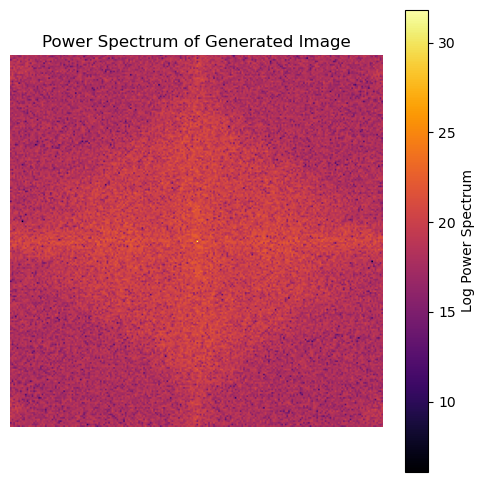

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and convert image to grayscale
image = final_image.convert("L")
image_array = np.array(image, dtype=np.float32)

# Compute 2D FFT
fft_result = np.fft.fft2(image_array)
fft_shifted = np.fft.fftshift(fft_result)  # Shift low frequencies to the center

# Compute power spectrum (magnitude squared)
power_spectrum = np.abs(fft_shifted) ** 2

# Convert to logarithmic scale for better visualization
log_power_spectrum = np.log1p(power_spectrum)

# Plot power spectrum
plt.figure(figsize=(6, 6))
plt.imshow(log_power_spectrum, cmap="inferno")
plt.colorbar(label="Log Power Spectrum")
plt.title("Power Spectrum of Generated Image")
plt.axis("off")
plt.show()


---

Step 0/100, Loss: -25.917184829711914
Step 50/100, Loss: -47.990272521972656


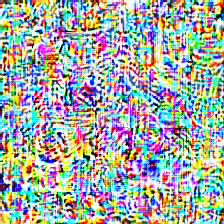

In [72]:
target_text = ["a photo of a cat"]
inputs = train_adversarial_example(target_text, [i for i in range(1, 225)], num_steps=100)

final_image = denormalize(inputs['pixel_values'].detach().cpu())
final_image


In [74]:
predict_similarity(transforms.ToTensor()(final_image).unsqueeze(0), texts)

array([[9.997155e-01, 2.845117e-04]], dtype=float32)

In [8]:
from transformers import CLIPProcessor, CLIPModel

model_name = "immich-app/laion2b_s34b_b79k"

# Load model and processor
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

print(f"Loaded {model_name} successfully!")


OSError: immich-app/laion2b_s34b_b79k is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`